# Extração de dados a partir de vídeos
### Extração de imagens, alvos e criação de folds
Neste notebook jupyter de exemplo, veremos como usar o código de análise de som em tráfego para fazer a extração de dados a partir de vídeos. Inicaremos esse código simplesmente com um par de vídeos, e ao final teremos um dataset completo e pronto para ser utilizado, com apenas algumas linhas de códigos.

Primeiramente, vamos importar algumas bibliotecas, incluindo a nossa biblioteca de tráfego

In [1]:
import os, sys
import numpy as np

# Adiciona a pasta TrafficSoundAnalysis para o 'PATH', para que o python reconheça nosso pacote 
sys.path.append(os.path.dirname(os.path.abspath('')))

# Importa a classe DataHandler da nossa biblioteca de trafego
from TrafficSoundAnalysis.DataHandler.DataHandler import *

In [2]:
# Isso aqui é para resolve um problema de 'Out Of Memory' na minha gpu (GTX 1650)
# https://stackoverflow.com/questions/59873568/unknownerror-failed-to-get-convolution-algorithm
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

Para executar esse código, precisaremos primeiro criar o seguinte diretório: **traffic-analysis/Exemples/dataset/raw**

In [3]:
# dataset_dir = '/home/.../traffic-analysis/Examples/dataset'
dataset_dir = os.path.join(os.path.abspath(''), "dataset")

#   Cria a pasta 'dataset' em 'Examples/dataset'
if not os.path.isdir(dataset_dir):
    os.makedirs(dataset_dir)
#   Cria a pasta 'raw' em 'Examples/dataset/raw'
if not os.path.isdir(os.path.join(dataset_dir, "raw")):
    os.makedirs(os.path.join(dataset_dir, "raw"))

Agora vamos baixar um vídeo para extrair suas imagens / audio.

Para isso, basta pegar qualquer vídeo da internet e colocar na pasta criada 'Examples/dataset/raw'.

Testei os formatos .mp4 e .mpeg, e é importante que ao colocar o vídeo não tenha nenhum 'espaço' no nome dele (se não o script irá reclamar!)

Como isso é somente uma demonstração, nesse exemplo estarei usando esses 3 vídeos no formato 360p

1. Buzzing Malaysian Road Traffic (Kuala Lumpur) - https://www.youtube.com/watch?v=cIlssGFDOns

2. Object detection using deep learning dataset cctv road video - https://www.youtube.com/watch?v=cDuVtH0CZek

3. Relaxing highway traffic - https://www.youtube.com/watch?v=nt3D26lrkho

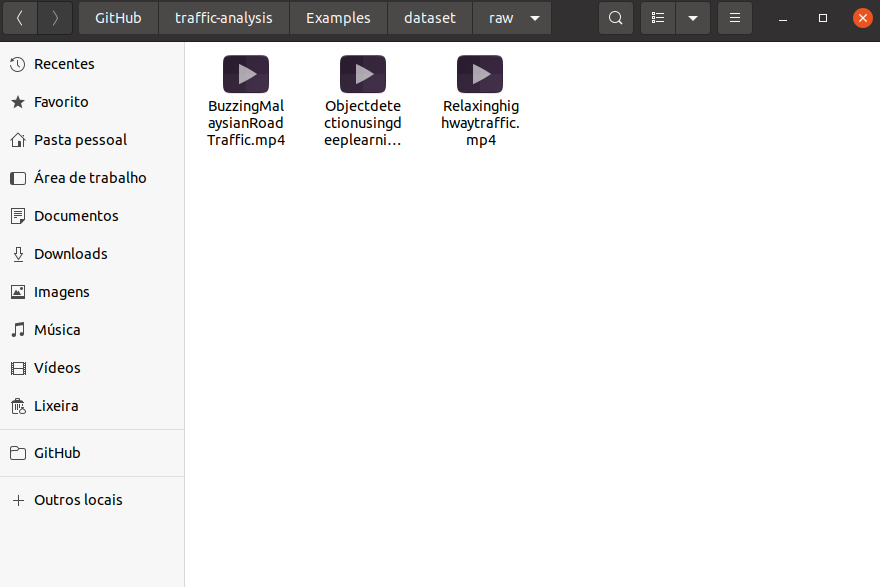

Vamos criar um objeto 'DataHandler'
Esse objeto é responsável por todas as operações que envolvem dados no projeto, inclusive a geração deles. Vamos estar usando aqui alguns métodos implementados nessa classe.

In [4]:
# Cria o objeto dataHandler
dataHandler = DataHandler(dataset_directory = dataset_dir)

E agora vamos extrair os dados dos nossos vídeos.

Para isso, vamos utilizar o método _ExtractDataFromRawVideos_ da classe _DataHandle_.

Essa classe irá automaticamente verificar todos os _novos vídeos_ adicionados na pasta 'raw', e gerará para cada vídeo um pasta correspondente. Dentro dessas pastas nós iremos encontrar alguns arquivos, explicado mais detalhadamente a seguir

In [5]:
# Método que faz toda a extração dos dados dos vídeos
# Como isso é apenas um tutorial, iremos utilizar um fator de downsampling alto, e um formato de imagem pequeno,
# de modo a diminuir o volume de dados gerados.

dataHandler.ExtractDataFromRawVideos(downsampling_factor=100, image_format = [64, 64, 3])

[INFO]: Starting image extraction process
[INFO]: Basepath of this dataset: /home/titan/GitHub/traffic-analysis/Examples/dataset
[INFO]: Downsampling factor of extraction: 100
[INFO]: Format of extracted images: [64, 64, 3]
[INFO]: Reading filepath off all videos
[WARNING]: Could not find dataset configuration file. Creating one
[INFO]: The following new videos were added to the dataset
	BuzzingMalaysianRoadTraffic.mp4
	Objectdetectionusingdeeplearningdatasetcctvroadvideo.mp4
	Relaxinghighwaytraffic.mp4
[INFO]: Extracting frames from video BuzzingMalaysianRoadTraffic.mp4
[INFO]: 146 frames were extracted from video BuzzingMalaysianRoadTraffic.mp4
[INFO]: Extracting audio information from video BuzzingMalaysianRoadTraffic.mp4
[INFO]: Reading audio file ...
[INFO]: Calculating audio power for each frame ...
[INFO]: Extracting frames from video Objectdetectionusingdeeplearningdatasetcctvroadvideo.mp4
[INFO]: 423 frames were extracted from video Objectdetectionusingdeeplearningdatasetcctvr

Vamos olhar os arquivos gerados após esse processo:

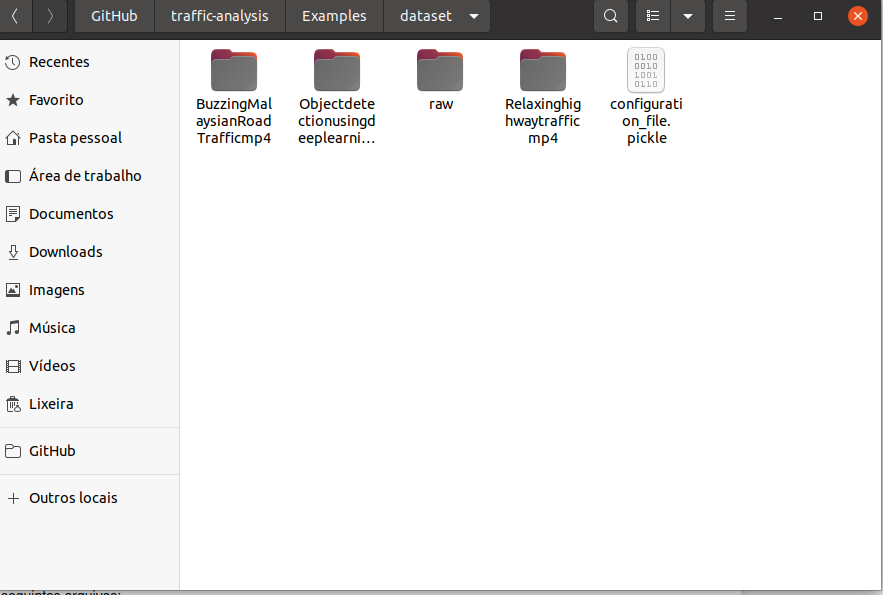

Podemos verificar que agora existem 3 novas pastas. Cada pasta contém os dados extraídos para o vídeo em questão.

Dentro de cada pasta encontraremos os seguintes arquivos:

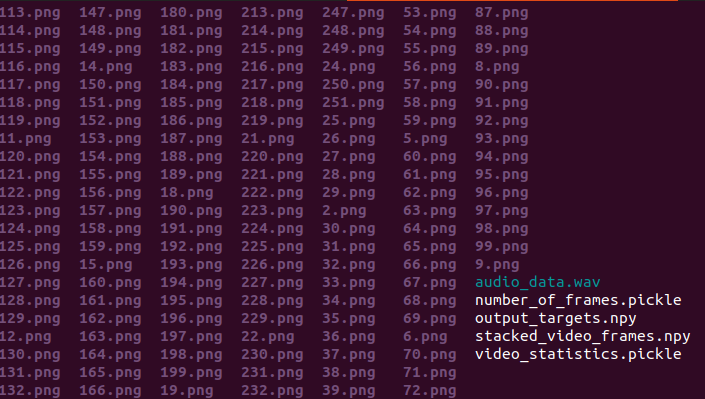

1. **\*.png** - Imagem png correpondente ao frame nº X

2. **audio_data.wav** - arquivo de audio extraído do vídeo

3. **number_of_frames.pickle** - arquivo contendo qual o número total de frames extraídos nessa pasta

4. **output_targets.npy** - arquivo contendo os alvos calculados a partir do audio extraído dos vídeos

5. **stacked_video_frames.npy** - tensor numpy contendo todos os frames empilhados e não-normalizados (em formato np.uint8, nesse exemplo com formato \[frames, 128, 128, 3\], onde 3 é o número de canais de cor)

6. **video_statistics.pickle** - arquivo contendo informação referente à média e desvio padrão dos pixel dos vídeo por canal

Vamos vizualizar algumas imagens desse arquivo de imagens empilhadas

stacked_video_frames.shape (146, 64, 64, 3)
Imagem número 1


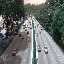

Imagem número 50


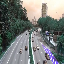

Imagem número 100


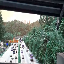

In [6]:
from PIL import Image               # to load images
from IPython.display import display # to display images

# Carrega o arquivo de images empilhas do vídeo BuzzingMalaysianRoadTraffic.mp4
stacked_video_frames = np.load(os.path.join(os.path.abspath(''), "dataset", "BuzzingMalaysianRoadTrafficmp4", "stacked_video_frames.npy"))

print("stacked_video_frames.shape", stacked_video_frames.shape)
print("Imagem número 1")
img = Image.fromarray(stacked_video_frames[1], 'RGB')
display(img)
print("Imagem número 50")
img = Image.fromarray(stacked_video_frames[50], 'RGB')
display(img)
print("Imagem número 100")
img = Image.fromarray(stacked_video_frames[100], 'RGB')
display(img)

Com esses dados extraídos, já é possível carregarmos um tensor de dados contendo o conteúdo desses vídeos. Para isso, podemos o método DataHandle.LoadDataset, da seguinte forma:

In [7]:
# Primeiro, criamos um dicionário python. Nesse dicionário registramos o nome dos vídeos de treinamento e teste
# contendo em cada fold
# Esse dicionário contém as especificações de qual vídeo é teste e qual vídeo é treino
# Vamos criar 3 folds diferentes, alternando 2 vídeos para treinamento e 1 para teste:

number_of_folds = 3
folds = [dict() for i in range(number_of_folds)]

for i in range(number_of_folds):
    folds[i]["name"] = "fold_"+str(i)
    folds[i]["number"] = i

# Fold 0
folds[0]["training_videos"] = ["BuzzingMalaysianRoadTraffic.mp4","Objectdetectionusingdeeplearningdatasetcctvroadvideo.mp4"]
folds[0]["testing_videos"] = ["Relaxinghighwaytraffic.mp4"]

# Fold 1
folds[1]["training_videos"] = ["BuzzingMalaysianRoadTraffic.mp4","Relaxinghighwaytraffic.mp4"]
folds[1]["testing_videos"] = ["Objectdetectionusingdeeplearningdatasetcctvroadvideo.mp4"]

# Fold 2
folds[2]["training_videos"] = ["Relaxinghighwaytraffic.mp4","Objectdetectionusingdeeplearningdatasetcctvroadvideo.mp4"]
folds[2]["testing_videos"] = ["BuzzingMalaysianRoadTraffic.mp4"]

In [8]:
# Agora vamos carregar os dataset para o 'fold_0'.
# Esse dataset já está no formato necessário para passarmos para o treinamento de uma rede 'vgg16' com 'gap'
[
    train_input,
    train_output,
    test_input,
    test_output,
] = dataHandler.LoadDataset(folds[0], CNN='vgg16', Pooling='gap')

[INFO]: Loading non-extracted data from fold fold_0
[INFO]: Loading data
[INFO]: Starting building process for train dataset
[INFO]: Size of ndarray of type np.uint8: 6.66796875 mb
[INFO]: Size of ndarray of type np.ufloat32: 26.671875 mb
[INFO]: Starting building process for test dataset
[INFO]: Fold built is complete


In [9]:
# Vamos olha o formato desses dados

print("train_input.shape:", train_input.shape)
print("train_output.shape:", train_output.shape)

train_input.shape: (563, 3, 64, 64, 3)
train_output.shape: (563,)


### Extração de _image features_ a partir dos folds criados

Apesar de nós podermos usar esses dados do jeito que estão para um treinamento de rede convolucional, uma coisa que vamos notar é que esse volume de dados é muito alto e tende a crescer muito rapidamente. 

Para contornar isso, optamos por utilizar redes convolucionais pré-treinadas, de forma a utiliza-las sem fazer o treinamento de suas camadas convolucionais. Isso nos permite diminuir o volume de dados, pois no lugar de salvarmos os arquivos de imagens, podemos salvar simplesmente a saída dessas redes. Vamos ver isso agora

Primeiramente, será interessante para nós salvarmos alguns arquivos gerados pelo método _LoadDataset_ (Mais especificamente, geradas pela função privada _CreateFoldFromExtractedData_), para que não precisemos chama-lo toda vez que quisermos obter os dados de um determinado fold, o que aumenta a velocidade do código.

Podemos salvar todos os folds que quisermos criar com o método _CreateAndSaveFoldsToDisk_, passando apenas o dicionário python anteriormente criado.

In [10]:
# Método que cria e salva todos os folds especificados pelo arquivo de 'folds' 
dataHandler.CreateAndSaveFoldsToDisk(folds)

[INFO]: Creating fold 0
[INFO]: Loading data
[INFO]: Starting building process for train dataset
[INFO]: Size of ndarray of type np.uint8: 6.66796875 mb
[INFO]: Size of ndarray of type np.ufloat32: 26.671875 mb
[INFO]: Starting building process for test dataset
[INFO]: Fold built is complete
[INFO]: Saving fold 0 to disk
[INFO]: Creating fold 1
[INFO]: Loading data
[INFO]: Starting building process for train dataset
[INFO]: Size of ndarray of type np.uint8: 4.6640625 mb
[INFO]: Size of ndarray of type np.ufloat32: 18.65625 mb
[INFO]: Starting building process for test dataset
[INFO]: Fold built is complete
[INFO]: Saving fold 1 to disk
[INFO]: Creating fold 2
[INFO]: Loading data
[INFO]: Starting building process for train dataset
[INFO]: Size of ndarray of type np.uint8: 7.91015625 mb
[INFO]: Size of ndarray of type np.ufloat32: 31.640625 mb
[INFO]: Starting building process for test dataset
[INFO]: Fold built is complete
[INFO]: Saving fold 2 to disk
[INFO]: All folds are saved on th

Podemos verificar que existe agora uma pasta 'dataset/folds', com todos os arquivos numpy de folds gerados. Esses arquivos são os mesmos gerados pelo método privado _CreateFoldFromExtractedData_, o qual o usuário não tem acesso, e executados de maneira automatizada.

Com isso feito, podemos agora facilmente extrair a _features_ de nosso banco de dados usando uma rede convolucional. Nesse exemplo, vamos utilizar uma rede **vgg16** com uma camada de **global average pooling**, usando o método _ExtractImageFeaturesFromFoldsOnDisk_

In [11]:
# Método que faz a extração das features dos folds salvos no disco
dataHandler.ExtractImageFeaturesFromFoldsOnDisk(folds, image_format = [64, 64, 3], cnn='vgg16', pooling='gap')

[INFO]: Extraction network summary:
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
Total params: 14,714,688
Trainable params: 0
Non-trainable params: 14,714,688
_________________________________________________________________
[INFO]: Loading dataset from fold_0
[INFO]: Extracting training features
[INFO]: Saving training features
[INFO]: Extracting testing features
[INFO]: Saving testing features
[INFO]: Loading dataset from fold_1
[INFO]: Extracting training features
[INFO]: Saving training features
[INFO]: Extracting testing features
[INFO]: Saving testing feat

Dentro da pasta _folds_ haverá agora uma nova pasta chamada _vgg16_. Dentro dessa pasta se encontra agora os arquivos de entrada com as _features_ extraídas utilizando a vgg16 para as imagens em cada fold. Dessa forma, não é mais necessário carregarmos todas as imagens durante nossa etapa de treinamento, diminuindo muito o volume de dados.

Agora que passamos por essa última etapa, podemos novamente chamar o método _LoadDataset_ para carregamento de dados para o treinamento de redes neurais, passando dessa vez o parâmetro _cnn_offline=True_. Dessa forma, a geração de dados não será executada dinâmicamente, e carregaremos apenas as features pré-calculadas no lugar dos arquivos de imagens completos, o que aumenta muito a velocidade de processamento. Vamos comparar:

In [12]:
# Carregará os dados do fold_0 de entrada e saída para um rede neural vgg16 com gap e sem camada LSTM
# Usando 'cnn_offline=False'

import time

start_time = time.time()
[
    x_train,
    y_train,
    x_test,
    y_test
] = dataHandler.LoadDataset(folds[0],
                            CNN="vgg16",
                            Pooling="gap",
                            LSTM=False,
                            image_format = [64,64,3])

print_info("Levamos {:.2f}".format(time.time() - start_time)+" segundos para carregar o dataset!")

[INFO]: Loading non-extracted data from fold fold_0
[INFO]: Loading data
[INFO]: Starting building process for train dataset
[INFO]: Size of ndarray of type np.uint8: 6.66796875 mb
[INFO]: Size of ndarray of type np.ufloat32: 26.671875 mb
[INFO]: Starting building process for test dataset
[INFO]: Fold built is complete
[INFO]: Dataset loaded sucessefully
[INFO]: Levamos 0.05 segundos para carregar o dataset!


In [13]:
# Vamos especionar o formato dos dados:
print("x_train.shape", x_train.shape)
print("y_train.shape", y_train.shape)
print("x_test.shape", x_test.shape)
print("y_test.shape", y_test.shape)

x_train.shape (569, 64, 64, 3)
y_train.shape (569,)
x_test.shape (252, 64, 64, 3)
y_test.shape (252,)


In [14]:
# Carregará os dados do fold_0 de entrada e saída para um rede neural vgg16 com gap e sem camada LSTM
# Usando 'cnn_offline=True'
start_time = time.time()
[
    x_train,
    y_train,
    x_test,
    y_test
] = dataHandler.LoadDataset(folds[0],
                            CNN_offline=True,
                            CNN="vgg16",
                            Pooling="gap",
                            LSTM=False,
                            image_format = [64,64,3])

print_info("Levamos {:.2f}".format(time.time() - start_time)+" segundos para carregar o dataset!")

[INFO]: Loading CNN extracted features from fold fold_0
[INFO]: Dataset loaded sucessefully
[INFO]: Levamos 0.01 segundos para carregar o dataset!


In [15]:
# Vamos notar que agora os tensores são menores, contendo apenas as features pré-calculadas:
print("x_train.shape", x_train.shape)
print("y_train.shape", y_train.shape)
print("x_test.shape", x_test.shape)
print("y_test.shape", y_test.shape)

x_train.shape (569, 512)
y_train.shape (569,)
x_test.shape (252, 512)
y_test.shape (252,)


Vamos ver outros formatos de tensores para outras estruturas de redes:

In [16]:
# Carregará os dados do fold_0 de entrada e saída para um rede neural vgg16 com gap,
# camada LSTM tamanho de janela = 10 frames, sem superposição entre janelas 

[
    x_train,
    y_train,
    x_test,
    y_test
] = dataHandler.LoadDataset(folds[0],
                            CNN="vgg16",
                            Pooling="gap",
                            LSTM=True,
                            time_steps=10,
                            overlap_windows=False,
                            image_format = [64,64,3])

[INFO]: Loading non-extracted data from fold fold_0
[INFO]: Loading data
[INFO]: Starting building process for train dataset
[INFO]: Size of ndarray of type np.uint8: 6.66796875 mb
[INFO]: Size of ndarray of type np.ufloat32: 26.671875 mb
[INFO]: Starting building process for test dataset
[INFO]: Fold built is complete


In [17]:
# Vamos especionar o formato dos dados:
print("x_train.shape", x_train.shape)
print("y_train.shape", y_train.shape)
print("x_test.shape", x_test.shape)
print("y_test.shape", y_test.shape)

x_train.shape (56, 10, 64, 64, 3)
y_train.shape (56, 10)
x_test.shape (25, 10, 64, 64, 3)
y_test.shape (25, 10)


In [18]:
# Carregará os dados do fold_0 de entrada e saída para um rede neural vgg16 com gap,
# camada LSTM tamanho de janela = 3 frames, com superposição entre janelas e predição no último frame da janela

[
    x_train,
    y_train,
    x_test,
    y_test
] = dataHandler.LoadDataset(folds[0],
                            CNN="vgg16",
                            Pooling="gap",
                            LSTM=True,
                            time_steps=3,
                            overlap_windows=True,
                            causal_prediction=True,
                            image_format = [64,64,3])

[INFO]: Loading non-extracted data from fold fold_0
[INFO]: Loading data
[INFO]: Starting building process for train dataset
[INFO]: Size of ndarray of type np.uint8: 6.66796875 mb
[INFO]: Size of ndarray of type np.ufloat32: 26.671875 mb
[INFO]: Starting building process for test dataset
[INFO]: Fold built is complete


In [19]:
# Vamos especionar o formato dos dados:
print("x_train.shape", x_train.shape)
print("y_train.shape", y_train.shape)
print("x_test.shape", x_test.shape)
print("y_test.shape", y_test.shape)

x_train.shape (563, 3, 64, 64, 3)
y_train.shape (563,)
x_test.shape (249, 3, 64, 64, 3)
y_test.shape (249,)


Isso encerra esse tutorial sobre extração e carregamento de dados no projeto. Espero que isso ajude no desenvolvimento futuro de modelos mais complexos.

^-^

Matheus Lima